# DATA6810 - Assignment 1

## Bayesian Linear Regression and Gaussian Processes

**Semester 1, March 2022**



Lecturers and Tutors: Roman Marchant

## Background Description

The goal is to produce an estimate of global mean *sea level* from regression models for specific dates. The source of data for this assignment is the historical sea level data from setellite altimetry (NOAA, Laboratory for Satellite Altimetry).

The data can be downloaded from [NOASS'S website](https://www.star.nesdis.noaa.gov/socd/lsa/SeaLevelRise/LSA_SLR_timeseries_global.php), and we are specifically interested in a subset of the data correspondig to the [Jason-2 satellite](https://www.jplt.nasa.gov/missions/jason-2), where seasonal signals are retained. The CSV file can be found [here](https://www.star.nesdis.noaa.gov/socd/lsa/SeaLevelRise/slr/slr_sla_gbl_keep_txj1j2_90.csv).

The task is the following:

1. Download and normalise the data provided by Jason-2 satellite.
2. Use bayesian linear regression and gaussian processes to predict the value of mean sea level (in [mm], not normalised) for two dates: t_1 = 2013.2265 and for t_2 = 2017.5012. You are expected to provide the full predictive gaussian distribution for these dates for the two methods, including the expected value and variance. Make whatever assumptions you deem necessary commenting on the justifications, including the family of basis functions, $\alpha$ and $\beta$ for BLR and the kernel function for GPs.

3. Comment on the suitability of the different methods for prediction sea level in both dates in (2). (max 300 words)

You are encouraged to re-use most of the code from the tutorials and deliver this python notebook as a completed file with your anlaysis.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Part 1 - Download and Normalise data

In [2]:
# Read the data from csv
data = pd.read_csv('slr_sla_gbl_keep_txj1j2_90.csv', comment='#')
jason_2_data = data[['year', 'Jason-2']].dropna()
jason_2_data.head()

,year,Jason-2
634,2008.5425,19.74
635,2008.5695,20.04
637,2008.5968,19.34
638,2008.6238,23.24
639,2008.6507,23.24


x has shape (301,1) and has range [2008.543,2016.741]
y has shape (301,1) and has range [15.640,64.240]


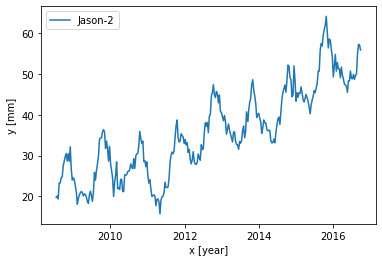

In [3]:
# Plot Jason-2 data
jason_2_data.plot(x='year', y='Jason-2', kind='line')
plt.xlabel('x [year]')
plt.ylabel('y [mm]')

x = jason_2_data['year'].values[:,np.newaxis]
y = jason_2_data['Jason-2'].values[:,np.newaxis]

print(f"x has shape ({x.shape[0]},{x.shape[1]}) and has range [{np.min(x):.3f},{np.max(x):.3f}]")
print(f"y has shape ({y.shape[0]},{y.shape[1]}) and has range [{np.min(y):.3f},{np.max(y):.3f}]")

### Normalize the data

In [4]:
def normalise1D(z, new_min=0, new_max=1): 
    z_min = np.min(z)
    z_max = np.max(z)
    z_normalised = new_min + (z - z_min)*(new_max - new_min)/(z_max - z_min) 
    return z_normalised

x_norm = normalise1D(x) 
y_norm = normalise1D(y)

## Part 2 - Train Bayesian Linear Regression and Gaussian Process

### Split train and test data

In [5]:
N = len(x)
train_ratio = 0.7
indices = np.arange(N)

# Shuffle indices
np.random.shuffle(indices)

# split training and testing indices
train_size = int(train_ratio * N)
train_indices = indices[:train_size]
test_indices = indices[train_size:]

# split training and testing sets
x_train, y_train = x_norm[train_indices], y_norm[train_indices]
x_test, y_test = x_norm[test_indices], y_norm[test_indices]


print(f"Training set contains {x_train.shape[0]} observations.")
print(f"Training set contains {x_test.shape[0]} observations.")

Training set contains 210 observations.
Training set contains 91 observations.


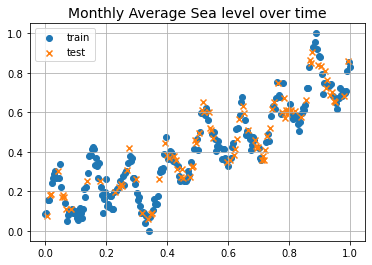

In [6]:
# Plot train and test data
plt.scatter(x_train, y_train, label='train')
plt.scatter(x_test, y_test, marker="x", label='test')
plt.title('Monthly Average Sea level over time', fontsize=14)
plt.legend()
plt.grid()

## Bayesian Linear Regression

Let us consider a isotropic gaussian prior: $\mathbf{m}_0=\mathbf{0}$ and $\mathbf{S}_0 = \alpha^{-1} \mathbf{I}$
\begin{equation}
    p(\mathbf{w}) = \mathcal{N} (\mathbf{w} \vert \mathbf{m}_0, \mathbf{S}_0)
\end{equation}

Then, the posterior is,
\begin{equation}
    p(\mathbf{w|t}) = \mathcal{N} (\mathbf{w} \lvert \mathbf{m}_N, \mathbf{S}_N)
\end{equation}

where $\mathbf{m_N} = \beta \mathbf{S}_N \mathbf{\Phi_x^\top t}$, and 
$\mathbf{S}_N = {( \alpha \mathbf{I} + \beta \mathbf{\Phi_x}^\top \mathbf{\Phi_x} )}^{-1}$.

Since there is a periodicity with trend (slope) in the data, I have chosen a sinusoidal basis function with a slope and intercept:
$$y = w_0 + w_1x + w_2 \sin{(2\omega x)}$$

In [7]:
def generate_feature_mat(x_in, omega):
    theta_x = np.concatenate([x_in**np.arange(2), np.sin(2*omega*x_in)], axis=1)
    return theta_x

Examine the effect of basis function parameter $\omega$ on predictions

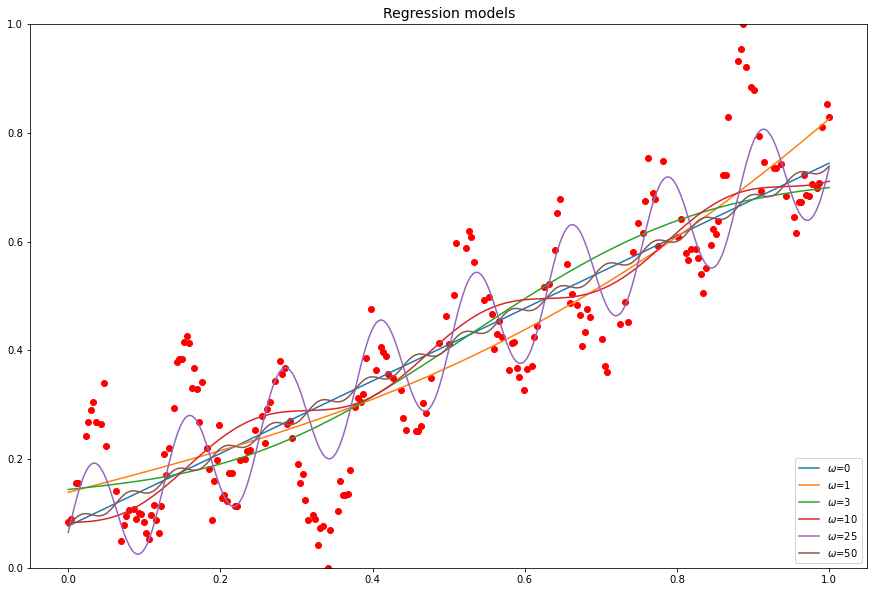

In [8]:
omega_vals = np.array([0,1,3,10,25,50])

x_q = np.linspace(0,1.0,300)[:,np.newaxis] 

plt.figure(figsize=(15,10))
plt.scatter(x_train, y_train, marker='o', color='r')

for omega in omega_vals:
    phi_x = generate_feature_mat(x_train, omega) 
    w_hat = (np.linalg.pinv(phi_x.T.dot(phi_x))).dot(phi_x.T.dot(y_train))
    phi_x_q = generate_feature_mat(x_q, omega)
    y_hat = phi_x_q.dot(w_hat)
    plt.plot(x_q, y_hat, label='$\omega$={}'.format(omega))
plt.title('Regression models', fontsize=14)
plt.legend(loc='lower right')
plt.ylim([0,1])
plt.show()

Since $\omega=25$ closely fits the data, I'll choose this value for training BLR. I also assume that $\beta$ is known, and equal to $50$ while the precision value for the prior $(\alpha)$ is set as $10$ 

In [9]:
# Empirically decided value of p
omega = 25
phi_x = generate_feature_mat(x_train, omega)

In [10]:
from scipy.stats import multivariate_normal

# Prior distribution
alpha = 10
prior = multivariate_normal(np.zeros(3), 1/alpha*np.eye(3))

# Posterior distribution
beta = 50
S_N = np.linalg.pinv(alpha*np.eye((3)) + beta*phi_x.T.dot(phi_x))
m_N = beta*S_N @ phi_x.T @ y_train

posterior = multivariate_normal(m_N[:,0], S_N)

Predictive distribution is given by,
\begin{equation}
    p(y \lvert x_q, \mathbf{x, y}, \alpha, \beta) = \mathcal{N}(\mu_q, \sigma^2_q)
\end{equation}

where $\mu_q = \mathbf{m}_N^\top \mathbf{\Phi_{x_q}^\top}$ and
$\sigma^2_q = \beta^{-1} + \mathbf{\Phi_{x_q}} \mathbf{S}_N \mathbf{\Phi_{x_q}}^\top$.

In [11]:
def predictive_distribution(x, beta):
    phi_x_q = generate_feature_mat(x, omega) 

    S = phi_x_q.dot(S_N.dot(phi_x_q.T))

    mu_q = m_N.T.dot(phi_x_q.T).ravel()
    sigma_q = np.sqrt(np.diag(phi_x_q.dot(S_N.dot(phi_x_q.T))) + 1.0 / beta)

    return mu_q, sigma_q

Text(0.5, 1.0, 'Bayesian linear regression ')

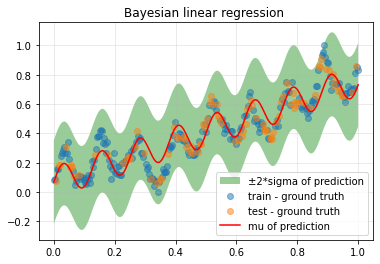

In [12]:
mu_q, sigma_q = predictive_distribution(x_norm, beta)

plt.grid(alpha=0.3)
plt.fill_between(x_norm.ravel(), mu_q-2*sigma_q, mu_q+2*sigma_q, \
                facecolor='green', interpolate=True, alpha=0.4, label='±2*sigma of prediction')
plt.scatter(x_train, y_train, label='train - ground truth', alpha=0.5)
plt.scatter(x_test, y_test, label='test - ground truth', alpha=0.5)
plt.plot(x_norm, mu_q, c='red', label='mu of prediction')
plt.legend(loc='lower right')
plt.title('Bayesian linear regression ')

## Predict on unseen test points

In [13]:
x_star = np.asarray([2013.2265, 2017.5012])[:, np.newaxis]
x_star_norm = (x_star - np.min(x))/(np.max(x) - np.min(x))
x_star_norm

array([[0.57131705],
       [1.09271095]])

In [15]:
phi_x_q = generate_feature_mat(x_star_norm, omega)

S = phi_x_q.dot(S_N.dot(phi_x_q.T))

# Equation above
mu_q = m_N.T.dot(phi_x_q.T).ravel()
sigma_q = np.sqrt(np.diag(phi_x_q.dot(S_N.dot(phi_x_q.T))) + 1.0 / beta)

results = pd.DataFrame({
    'year': x_star.flatten(),
    'sea_lvl_BLR_mean': mu_q * (y.max() - y.min()) + y.min(),
    'sea_lvl_BLR_var': (sigma_q * (y.max() - y.min()))**2
 })

results

,year,sea_lvl_BLR_mean,sea_lvl_BLR_var
0,2013.2265,36.684667,47.512708
1,2017.5012,50.868527,48.683475


## Gaussian Process

The choice of kernel function is squared exponential covariance function, written as:

\begin{equation}
k(\mathbf{x}_1,\mathbf{x}_2) = \sigma_f e\left(- \frac{1}{2}\frac{||\mathbf{x}_1-\mathbf{x}_2||}{\ell} \right)
\end{equation}


In order to visualise the regression we need to calculate the posterior predictive distribution:

\begin{equation}
p(\mathbf{f}_* | \mathbf{X},\mathbf{y}, \mathbf{x}_*) = \mathcal{N}(\bar{\mathbf{f}}_*, \text{cov}(\mathbf{f}_*))
\end{equation}

\begin{equation}
\bar{\mathbf{f}}_* = K(\mathbf{x}_*,\mathbf{X})\left[ K(\mathbf{X},\mathbf{X}) + \sigma_n^2 I \right]^{-1}\mathbf{y}
\end{equation}

\begin{equation}
\text{cov}(\mathbf{f}_*) = K(\mathbf{x}_*,\mathbf{x}_*) - K(\mathbf{x}_*,\mathbf{X})\left[ K(\mathbf{X},\mathbf{X}) + \sigma_n^2 I \right]^{-1}K(\mathbf{X},\mathbf{x}_*)
\end{equation}

This class incorporates the caluclation of the log marginal likelihood – so we can find the best hyperparameters to fit the data:

\begin{equation}
p(\mathbf{y}|\mathbf{X}) = \int{p(\mathbf{y}|\mathbf{f},\mathbf{X})p(\mathbf{f}|X)}\text{d}\mathbf{f}
\end{equation}

\begin{equation}
\text{log}p(\mathbf{y}|\mathbf{X}) = -\frac{1}{2}\mathbf{y}^T\left(K+\sigma_n^2I\right)\mathbf{y} - \frac{1}{2}\text{log}|K+\sigma_n^2I|-\frac{n}{2}\text{log}2\pi
\end{equation}


In [16]:
class GP:
    def __init__(self, x_train, y_train, hyper_params, sigma_n):
        self.x_train = x_train
        self.y_train = y_train
        self.hyper_params = hyper_params #params[0] is signal variance, params[1] is lengthscale
        self.K = self.cov_func(self.x_train,self.x_train)
        self.sigma_n = sigma_n
        self.K_inv = np.linalg.pinv(self.K+np.eye(self.K.shape[0])*(self.sigma_n**2))
        
    def predict(self,x_star):
        k_star = self.cov_func(self.x_train,x_star)
        f_mean = np.dot(np.dot(np.transpose(k_star),self.K_inv),self.y_train)
        f_std = self.cov_func(x_star, x_star) - np.dot(np.dot(np.transpose(k_star),self.K_inv),k_star)+np.eye(x_star.shape[0])*(self.sigma_n**2)
        f_std = np.sqrt(np.diag(f_std))[:,np.newaxis]
        return [f_mean,f_std]

    def cov_func(self, x_1, x_2):
        x_1_sq = np.sum(np.square(x_1), 1)
        x_2_sq = np.sum(np.square(x_2), 1)
        d = (x_1_sq[:, None] + x_2_sq[None, :]) -2.*np.dot(x_1, x_2.T)
        d = np.sqrt(np.clip(d, 0, np.inf))/self.hyper_params[1]
        K = self.hyper_params[0] * np.exp(-0.5* np.square(d))
        return K
    
    def set_hyper_params(self, hyper_params, sigma_n):
        self.hyper_params = hyper_params
        self.K = self.cov_func(self.x_train,self.x_train)
        self.sigma_n = sigma_n
        self.K_inv = np.linalg.pinv(self.K+np.eye(self.K.shape[0])*(self.sigma_n**2))
        
    def log_marginal_likelihood(self):
        lml1 = -.5*np.dot(np.dot(np.transpose(self.y_train),self.K_inv),self.y_train)
        lml2 = -.5*np.log(
            np.clip(
                np.linalg.det(self.K+np.eye(self.K.shape[0])*(self.sigma_n**2)),
                1e-318,
                None
            )
        )
        lml3 = -.5*self.x_train.shape[0]*np.log(2*np.pi)
        return lml1+lml3+lml2
        

Log Marginal Likelihood: [[104.84187079]]


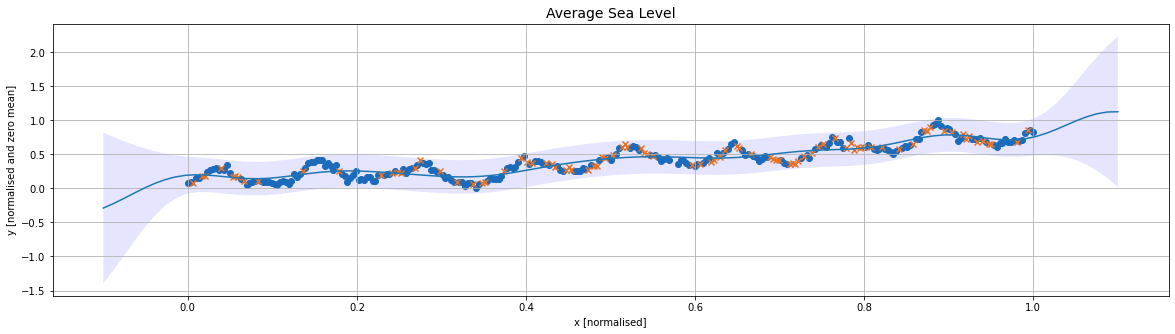

In [17]:
signal_variance, lengthscale, sigma_n = 0.8, 0.1, 0.12

x_star = np.linspace(-0.1, 1.1, 100)[:, np.newaxis]

gp = GP(x_train, y_train, [signal_variance,lengthscale], sigma_n)
[f_mean_2, f_std_2] = gp.predict(x_star)
lml = gp.log_marginal_likelihood()
print("Log Marginal Likelihood: "+str(lml))


fig = plt.figure(figsize=(20,5))
plt.scatter(x_train, y_train)
plt.scatter(x_test, y_test, marker="x")
plt.fill_between(x_star.ravel(), (f_mean_2-2*f_std_2).ravel(), (f_mean_2+2*f_std_2).ravel(), \
                facecolor='blue', interpolate=True, alpha=0.1, label='±2*sigma of prediction')
plt.plot(x_star, f_mean_2)
plt.title('Average Sea Level', fontsize=14)
plt.xlabel('x [normalised]')
plt.ylabel('y [normalised and zero mean]')
plt.grid()


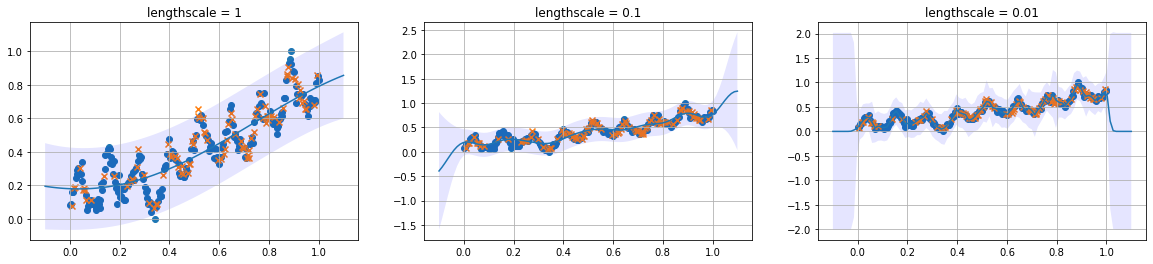

In [18]:
gp.set_hyper_params([1,1],sigma_n)
[f_mean_1,f_std_1] = gp.predict(x_star)

gp.set_hyper_params([1,0.1],sigma_n)
[f_mean_2,f_std_2] = gp.predict(x_star)

gp.set_hyper_params([1,0.01],sigma_n)
[f_mean_3,f_std_3] = gp.predict(x_star)


fig, ax = plt.subplots(1,3,figsize=(5*4,4))

ax[0].scatter(x_train, y_train)
ax[0].scatter(x_test, y_test,marker="x")
ax[0].fill_between(x_star.ravel(), (f_mean_1-2*f_std_1).ravel(), (f_mean_1+2*f_std_1).ravel(), \
                facecolor='blue', interpolate=True, alpha=0.1, label='±2*sigma of prediction')
ax[0].plot(x_star, f_mean_1)
ax[0].set_title('lengthscale = 1')
ax[0].grid()

ax[1].scatter(x_train, y_train)
ax[1].scatter(x_test, y_test,marker="x")
ax[1].fill_between(x_star.ravel(), (f_mean_2-2*f_std_2).ravel(), (f_mean_2+2*f_std_2).ravel(), \
            facecolor='blue', interpolate=True, alpha=0.1, label='±2*sigma of prediction')
ax[1].plot(x_star, f_mean_2)
ax[1].set_title('lengthscale = 0.1')
ax[1].grid()

ax[2].scatter(x_train, y_train)
ax[2].scatter(x_test, y_test,marker="x")
ax[2].fill_between(x_star.ravel(), (f_mean_3-2*f_std_3).ravel(), (f_mean_3+2*f_std_3).ravel(), \
                facecolor='blue', interpolate=True, alpha=0.1, label='±2*sigma of prediction')
ax[2].plot(x_star, f_mean_3)
ax[2].set_title('lengthscale = 0.01')
ax[2].grid()

### Optimize Hyperparameters
While trying to optimize the hyperparameters using `Nelder-Mead` optimizer, I noticed that for some values of hyperparameter (mostly where sigma_n is very small) the $det(K) \rightarrow 0$. The minimum workable value that I discovered was 1e-318. Thus, I have clipped the values on determinant to be in workable range.

In [19]:
from scipy.optimize import minimize

def eval_params(params, gp):
    params = np.exp(params)
    gp.set_hyper_params(params[:-1], params[-1])
    nlml = -gp.log_marginal_likelihood()
    print(str(params)+str(nlml))
    return nlml

x0 = np.array([np.log(1), np.log(0.08), np.log(0.11)])
res = minimize(eval_params, x0, args=(gp), method='Nelder-Mead')
print(res)

[1.   0.08 0.11][[-124.38428048]]
[1.00025003 0.08       0.11      ][[-124.38836546]]
[1.         0.07050899 0.11      ][[-145.34408805]]
[1.         0.08       0.09850592][[-116.77963336]]
[1.00016668 0.07354046 0.12283526][[-144.12230582]]
[1.00027782 0.06952653 0.11839852][[-149.10759318]]
[1.00041675 0.06481579 0.12283526][[-154.79809272]]
[1.0001389  0.06042423 0.12743826][[-158.1419193]]
[1.00008334 0.05251358 0.13716819][[-152.63448043]]
[1.00020372 0.05766309 0.1169555 ][[-157.11085823]]
[1.0005063  0.05259552 0.1360514 ][[-154.05481145]]
[1.0003797  0.0565943  0.12901061][[-159.69561869]]
[1.00006482 0.05226854 0.12588508][[-160.11500649]]
[0.9998889  0.04693752 0.12743826][[-160.24440721]]
[1.0000679  0.05121981 0.14000044][[-148.28142089]]
[1.00016977 0.05598001 0.12233419][[-158.68442627]]
[1.0001533  0.04645218 0.12503039][[-160.89297035]]
[1.00016051 0.04072898 0.12384357][[-158.26765135]]
[1.00011146 0.04427579 0.13215372][[-151.66656883]]
[1.00015519 0.05279178 0.124718

Plot the signal with optimized hyperparameters

Optimised value of signal_variance: 1.0017
Optimised value of lengthscale: 0.0318
Optimised value of sigma_n: 0.1107
Log Marginal Likelihood: [[162.36342958]]


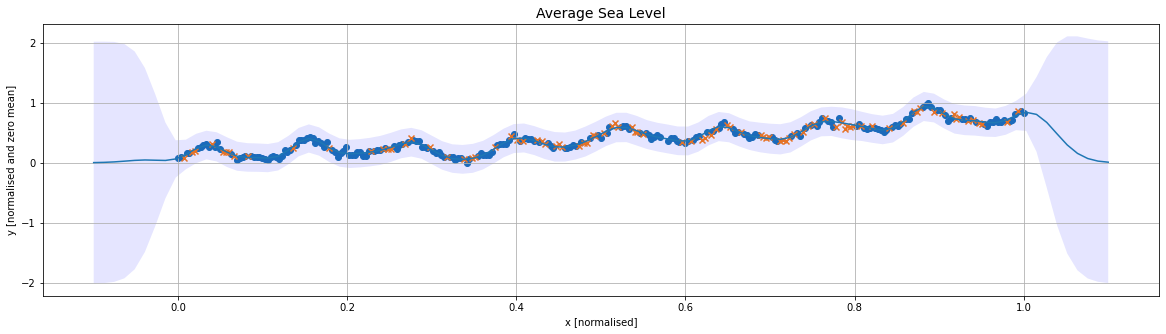

In [20]:
signal_variance, lengthscale, sigma_n = np.exp(res.x)

print(f"Optimised value of signal_variance: {signal_variance:.4f}")
print(f"Optimised value of lengthscale: {lengthscale:.4f}")
print(f"Optimised value of sigma_n: {sigma_n:.4f}")


x_star = np.linspace(-.1, 1.1, 100)[:, np.newaxis]

gp = GP(x_train, y_train, [signal_variance,lengthscale], sigma_n)
[f_mean_2, f_std_2] = gp.predict(x_star)
lml = gp.log_marginal_likelihood()
print("Log Marginal Likelihood: "+str(lml))


fig = plt.figure(figsize=(20,5))
plt.scatter(x_train, y_train)
plt.scatter(x_test, y_test, marker="x")
plt.fill_between(x_star.ravel(), (f_mean_2-2*f_std_2).ravel(), (f_mean_2+2*f_std_2).ravel(), \
                facecolor='blue', interpolate=True, alpha=0.1, label='±2*sigma of prediction')
plt.plot(x_star, f_mean_2)
plt.title('Average Sea Level', fontsize=14)
plt.xlabel('x [normalised]')
plt.ylabel('y [normalised and zero mean]')
plt.grid()

The model appears to be over fitting, as the prediction value becomes 0 out of sample x values. Therefore, I will stick with my original values of the hyperameters

### Prediction on unseen data

In [21]:
x_star = np.asarray([2013.2265, 2017.5012])
x_star_norm = (x_star - x.min()) / (x.max() - x.min())
x_star_norm = x_star_norm.reshape(-1, 1)

In [22]:
gp.set_hyper_params([1.0, 0.08], 0.11)
f_mean_2, f_std_2 = gp.predict(x_star_norm)

results.loc[:, 'sea_lvl_GP_mean'] = f_mean_2.ravel() * (y.max() - y.min()) + y.min()
results.loc[:, 'sea_lvl_GP_var'] = (f_std_2.ravel() * (y.max() - y.min()))**2

results


,year,sea_lvl_BLR_mean,sea_lvl_BLR_var,sea_lvl_GP_mean,sea_lvl_GP_var
0,2013.2265,36.684667,47.512708,36.897394,30.727853
1,2017.5012,50.868527,48.683475,70.416003,1130.468009


## Part 3 - Comment on suitability of prediction methods

The two dates for predicting the sea level given in part 2 are $T_1=2013.2265$ and $T_2=2017.5012$. Here, $T_1$ is within the range of the training data $[2008.543, 2016.741]$ while $T_2$ is outside the range of the available data. We use Bayesian Linear Regression (BLR) and Gaussian Process (GP) regression to predict the value of sea level at both these dates with uncertainty quantification via the predictive distribution.

In the case of BLR, I use a sinusoidal basis function along with a slope and intercept term to account for the periodicity and trend in the data. With this approach, I observed that the prediction variances for $T_1$ and $T_2$ were more balanced. While in the case of GP with a squared exponential kernel with optimised parameters, I obsersed that $Var[f(T_2)] >> Var[f(T_1)]$. This is because $T_2$ lies outside the range of the training data. 

For a large value of $T$ (outside the training data), with these configurations, the GP makes a 0 mean prediction with large variance. On the other hand, Bayesian Linear Regression predicts the sea level value defined by the basis function and weight parameters $\mathbf{w}$ and fixed precision parameter $\beta$. Based on these findings, I believe that BLR provides better projection for out of sample predictions while the GP may provide a better prediction for $T$ values within the range of the data.